## Emotion recognition from speech using transfer learning

This notebook is based on the great fastai library developed and mantained by Jeremy Howard and Rachel Thomas
https://github.com/fastai/fastai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys

print(sys.executable) #test environment

/home/asim/anaconda3/envs/tl-emotion/bin/python


In [2]:
from fastai import *
from fastai.vision import *
import numpy as np
import pandas as pd
import os.path
import librosa
import librosa.display
import IPython.display as ipd
from shutil import copyfile
import glob
import csv

print(os.getcwd()) #test cwd

/home/asim/Documents/emotion-from-speech


## Organizing audio data into folders according to class

* Each .csv file contain the .wav filenames associated with each emotion
* These .wav files are stored in 5 different folders, Session1, Session2 etc
* The next cell searches all the files associated with each emotion in those folders and stores them in specific folders organized by emotion
* The resulting audio files are stored in subflders inside the folder "audio"
* In tnis notebook we only consider the emotions "sadness", "anger", "happiness" and "neutral". Other classes could be include by modifying the code below

In [3]:
#finish the recording videos soon!!!

pathData = os.getcwd() + '/dataset-files'
wavData = pathData + '/original-emotions'
#pathAudio = pathData + 'audio/'
modelPath = os.getcwd() + '/models/'
pathAudio = pathData + '/audio/'#to-do
pathImage = pathData + '/image/'
! mkdir {pathAudio}
! mkdir {pathImage}

emotions = ['ang','dis', 'fea', 'hap', 'neu', 'sad', 'sur']

for emotion in emotions:
    pathAudioEmotion = pathAudio + emotion
    pathImageEmotion = pathImage + emotion
    ! mkdir {pathAudioEmotion}
    ! mkdir {pathImageEmotion}


mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/audio/’: File exists
mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/image/’: File exists
mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/audio/ang’: File exists
mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/image/ang’: File exists
mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/audio/dis’: File exists
mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/image/dis’: File exists
mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/audio/fea’: File exists
mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/image/fea’: File exists
mkdir: cannot create directory ‘/home/asim/Documents/emotion-from-speech/dataset-files/audio/hap’: File exists
mkdir: 

In [36]:
#ONLY RUN ONCE

for filename in os.listdir(wavData):
    if filename.endswith(".wav"): 
        #print(os.path.join(wavData, filename))
        #switch(filename[len(filename)-3:])
        index_emotion = len(filename)-7
        full_fname = os.path.join(wavData,filename)
        #print(filename[index_emotion:index_emotion+3])
        fname = filename[index_emotion:index_emotion+3]
        if fname == 'ang':
            copyfile(full_fname, os.path.join(pathAudio + 'ang', filename))
        elif fname == 'dis':
            copyfile(full_fname, os.path.join(pathAudio + 'dis', filename))
        elif fname == 'fea':
            copyfile(full_fname, os.path.join(pathAudio + 'fea', filename))
        elif fname == 'hap':
            copyfile(full_fname, os.path.join(pathAudio + 'hap', filename))
        elif fname == 'neu':
            copyfile(full_fname, os.path.join(pathAudio + 'neu', filename))
        elif fname == 'sad':
            copyfile(full_fname, os.path.join(pathAudio + 'sad', filename))
        elif fname == 'sur':
            copyfile(full_fname, os.path.join(pathAudio + 'sur', filename))
            
# for emotion in emotions:
#     print('Emotion: '+ emotion)
#     emotionFile = pd.read_csv(emotion[0:3]+'.csv')   
#     emotionFilenames = emotionFile['filenames']
#     for filename_target in emotionFilenames:
#         for filename in glob.iglob(wavData + '/**/' + filename_target + '.wav', recursive=True):
#             copyfile(filename, os.path.join(pathAudio + emotion, filename_target + '.wav'))

  
        

## Converting audio files into images based on spectrogram

The cells below create image files based on the signals in 'pathAudio' folder and store those images in 'pathImage' folder, orgazing the files in subfolders according to emotion class

I borrowed the functions in the cell below from https://dzlab.github.io/jekyll/update/2018/11/13/audio-classification/

In [4]:
def save_spectrogram(audio_fname, image_fname):
    y, sr = librosa.load(audio_fname, sr=None)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
    fig1 = plt.gcf()
    plt.axis('off')
    #plt.show() #dont draw these everytime anymore...
    #plt.draw()
    fig1.savefig(image_fname, dpi=100)

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def get_filename(path):
    absolute_fname = path.as_posix()
    absolute_fname_parts = absolute_fname.split('/')
    fname = absolute_fname_parts[len(absolute_fname_parts) - 1]
    return fname

def audio_to_spectrogram(audio_dir_path, image_dir_path=None):
    for paths in batch(audio_dir_path.ls(), 100): #change from 100
        for audio_path in paths:
            audio_filename = get_filename(audio_path)
            image_fname = audio_filename.split('.')[0] + '.png'
            if image_dir_path:
                image_fname = image_dir_path.as_posix() + '/' + image_fname
            if Path(image_fname).exists(): continue
            print(image_fname)
            #plot_spectrogram(image_fname)
            try:
                save_spectrogram(audio_path.as_posix(), image_fname)
            except ValueError as verr:
                print('Failed to process %s %s' % (image_fname, verr))
        # wait between every batch for xyz seconds


The cell below converts audio files to spectrogram images and organize them in different folder according to emotion

In [ ]:
for emotion in emotions:
    print('Emotion: ' + emotion)
    pathAudioEmotion = Path(pathAudio+emotion)
    pathImageEmotion = Path(pathImage+emotion)
    print(pathAudioEmotion)
    print(pathImageEmotion)
    audio_to_spectrogram(pathAudioEmotion, pathImageEmotion)
    

## Training ResNet model using transfer learning 

In [5]:
np.random.seed(42)

'''
original stats:

num_workers=4
valid_pct=0.2
size=[400,600], tried 40/60 (42), 200/300 (42), 275/475 (43), 300/450 (45)
'''

# data = ImageDataBunch.from_folder(pathImage, train='.', valid_pct=0.2,
#         ds_tfms=None, size=[275,475], num_workers=4).normalize(imagenet_stats) 

# data = ImageDataBunch.from_folder(pathImage, train='.', valid_pct=0.5,
#         ds_tfms=None, size=[300,450], num_workers=4).normalize(imagenet_stats) 

data = ImageDataBunch.from_folder(pathImage, train='.', valid_pct=0.2,
        ds_tfms=None, size=[300,450], num_workers=4).normalize(imagenet_stats) 

In [87]:
data.classes

#learn.destroy() #if exists

['ang', 'dis', 'fea', 'hap', 'neu', 'sad', 'sur']

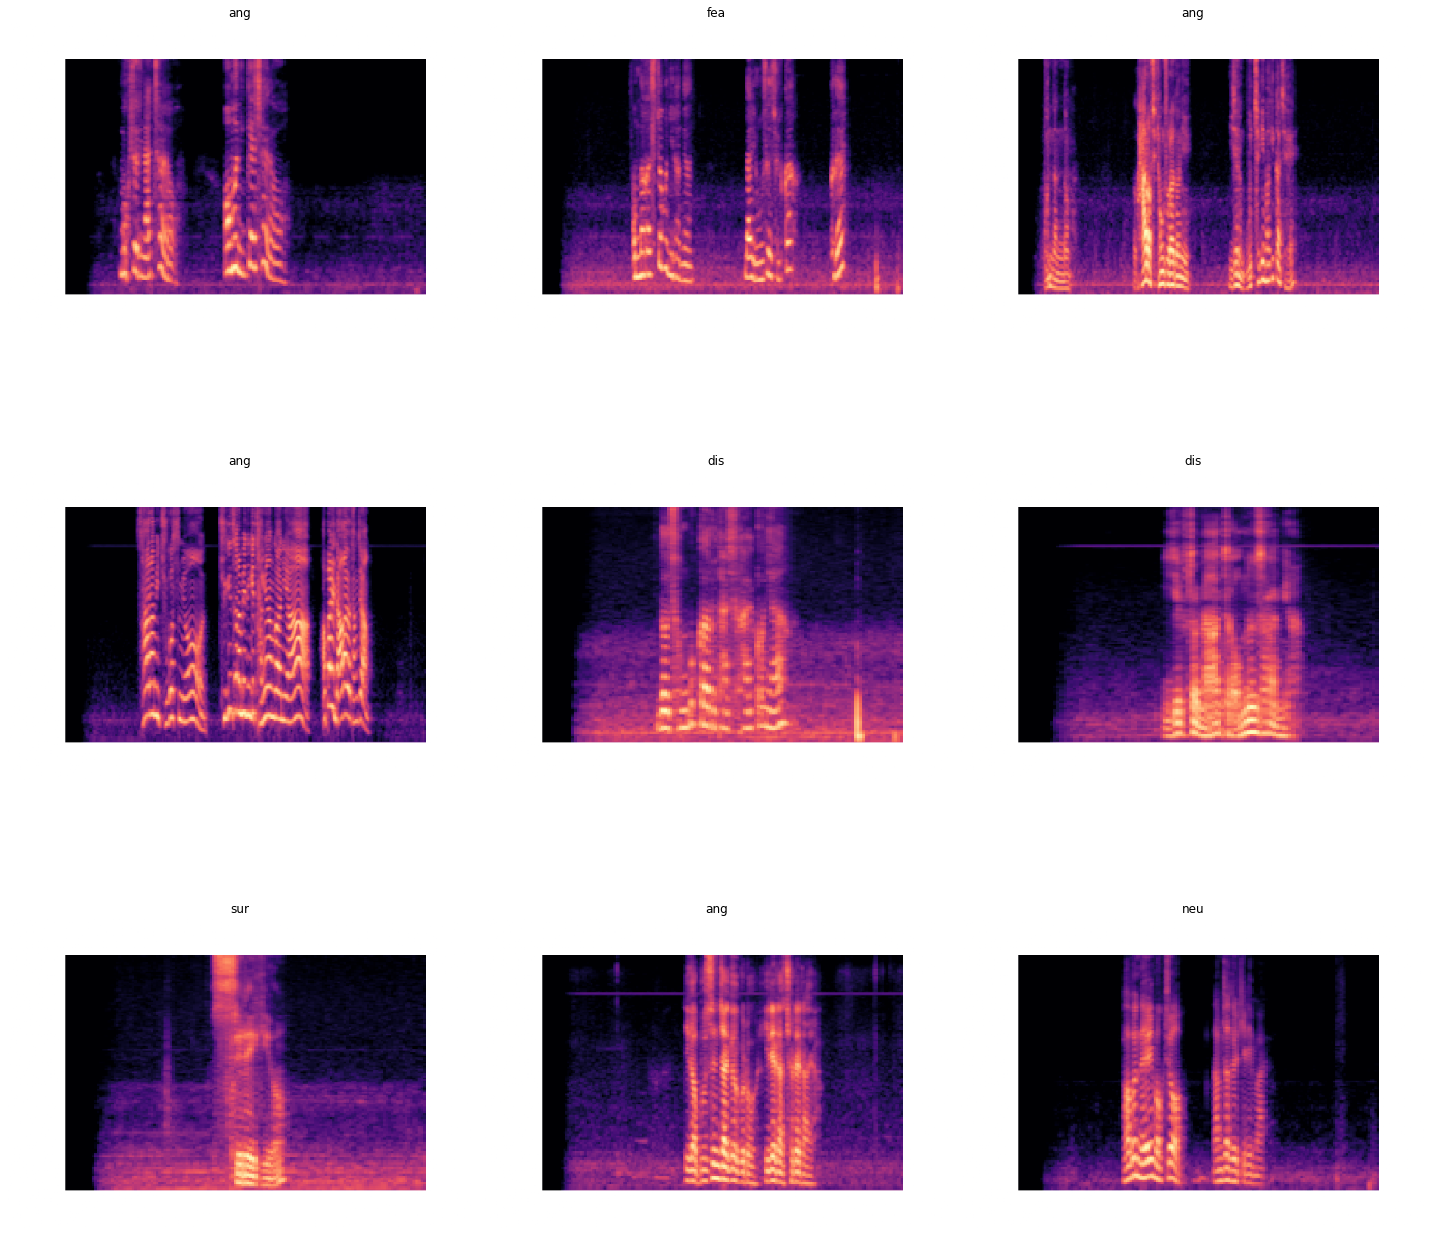

In [24]:
data.show_batch(rows=3,figsize=(20,20))

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [89]:
torch.cuda.empty_cache() #if not empty

#learn.fit_one_cycle(1)

#learn.load('stage-9v5-rn34')

learn.lr_find()
learn.recorder.plot()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/asim/anaconda3/envs/tl-emotion/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/asim/anaconda3/envs/tl-emotion/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/asim/anaconda3/envs/tl-emotion/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/asim/anaconda3/envs/tl-emotion/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/asim/anaconda3/envs/tl-emotion/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/asim/anaconda3/envs/tl-emotion/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/asim/anaconda3

KeyboardInterrupt: 

In [9]:
#lr = 1e-2
lr = 1e-1
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.167419,6.295397,0.203858,05:49
1,2.324796,2.287312,0.255400,05:48
2,1.976802,2.687710,0.279313,05:49
3,1.755923,1.727143,0.342811,05:42
4,1.647132,1.628160,0.379383,05:41


In [13]:
model_name = 'stage-17-rn34'

learn.save(modelPath+model_name, return_path= True) #NOTE, ARCHICTECTURE MUST BE THE SAME & ORIGINAL AS INPUT!

In [ ]:
#learn.load('stage-9-rn34')

In [40]:
learn.unfreeze() #helps release the model, allows layers to be trained again... (run everytime before training)

In [20]:
# learn.lr_find()
# learn.recorder.plot()

# everytime retraining
torch.cuda.empty_cache() #if not empty
model_name = 'stage-v11-c5-rn34' #MUST CHANGE THIS
learn = learn.load(Path(os.getcwd()+'/models/'+model_name))

# learn.lr_find()
# learn.recorder.plot()

In [41]:
torch.cuda.empty_cache() #if not empty
learn.unfreeze() #helps release the model, allows layers to be trained again... (run everytime before training)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


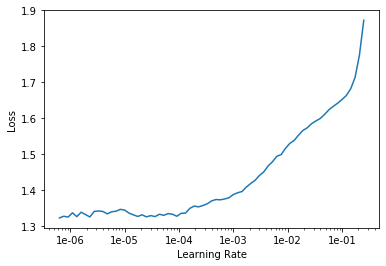

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
#best result comes on 3rd epoch

# learn.fit_one_cycle(10, slice(5e-7, lr/5)) #test improvement, also check size dimension change & analyze
lr = 1e-4 #uncomment only for second cycle
learn.fit_one_cycle(3, slice(1e-4, lr/3)) #test improvement, also check size dimension change & analyze

epoch,train_loss,valid_loss,accuracy,time
0,1.417623,1.552314,0.405807,10:02
1,1.405840,1.460137,0.448006,10:01
2,1.306504,1.443553,0.454235,10:21


In [27]:
"""
data = ImageDataBunch.from_folder(pathImage, train='.', valid_pct=0.2,
        ds_tfms=None, size=[300,450], num_workers=4).normalize(imagenet_stats) 
lr = 1e-1
learn.fit_one_cycle(5, slice(lr))
learn.fit_one_cycle(5, slice(1e-5, lr/5)) #test improvement, also check size dimension change & analyze
'stage-v11-c2-rn34' (42.9)

learn.fit_one_cycle(5, slice(1e-5, lr/5)) #test improvement, also check size dimension change & analyze
v11-c2 --> 'stage-v11-c4-rn34' (43.4)

lr = 1e-4 #uncomment only for second cycle
learn.fit_one_cycle(3, slice(1e-4, lr/3)) #test improvement, also check size dimension change & analyze
v11-c4 --> 'stage-v11-c5-rn34' (45.0)

lr = 1e-6 #uncomment only for second cycle
learn.fit_one_cycle(1, slice(1e-6, lr/1)) #test improvement, also check size dimension change & analyze
lr = 1e-5 #uncomment only for second cycle
learn.fit_one_cycle(2, slice(1e-5, lr/2)) #test improvement, also check size dimension change & analyze
lr = 1e-6 #uncomment only for second cycle
learn.fit_one_cycle(5, slice(1e-6, lr/5))
v11-c5 --> 'stage-v11-c6-rn34' (45.3)

lr = 1e-4 #uncomment only for second cycle
learn.fit_one_cycle(3, slice(1e-4, lr/3)) #test improvement, also check size dimension change & analyze
v11-c6 --> 'stage-v11-c7-rn34' (4)
"""

model_name = 'stage-v11-c7-rn34'

learn.save(modelPath+model_name, return_path=True)#300/450 or maybe 275/475

PosixPath('/home/asim/Documents/emotion-from-speech/models/stage-v11-c6-rn34.pth')

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

In [29]:
interp.most_confused(min_val=2)

[('dis', 'neu', 435),
 ('hap', 'neu', 394),
 ('sad', 'neu', 373),
 ('neu', 'sad', 251),
 ('dis', 'ang', 241),
 ('fea', 'sad', 232),
 ('fea', 'neu', 217),
 ('ang', 'neu', 216),
 ('ang', 'dis', 190),
 ('sur', 'neu', 177),
 ('neu', 'hap', 173),
 ('neu', 'dis', 155),
 ('dis', 'sad', 149),
 ('dis', 'sur', 140),
 ('fea', 'sur', 135),
 ('neu', 'sur', 115),
 ('sad', 'fea', 114),
 ('ang', 'sur', 112),
 ('dis', 'hap', 112),
 ('sur', 'ang', 104),
 ('sur', 'fea', 102),
 ('sad', 'dis', 95),
 ('sur', 'dis', 91),
 ('hap', 'sad', 90),
 ('ang', 'sad', 84),
 ('hap', 'dis', 68),
 ('neu', 'ang', 68),
 ('fea', 'dis', 66),
 ('dis', 'fea', 65),
 ('sad', 'hap', 64),
 ('fea', 'ang', 62),
 ('hap', 'sur', 62),
 ('neu', 'fea', 62),
 ('fea', 'hap', 57),
 ('sad', 'ang', 56),
 ('sur', 'hap', 56),
 ('hap', 'ang', 55),
 ('sur', 'sad', 50),
 ('ang', 'hap', 45),
 ('hap', 'fea', 40),
 ('ang', 'fea', 39),
 ('sad', 'sur', 38)]

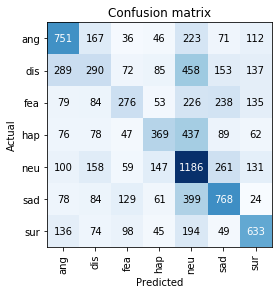

In [19]:
interp.plot_confusion_matrix()

In [20]:
print("Done!")

Done!


# example testing


In [35]:
#load model first
torch.cuda.empty_cache() #if not empty

model_name = 'stage-v11-c6-rn34' # REMEMBER TO CHANGE THIS EVERYTIME!
learn = learn.load(Path(os.getcwd()+'/models/'+model_name))

test = ImageList.from_folder(os.getcwd() + '/testset-files' + '/image2') #REMEMBER TO CHANGE THIS EVERY TIME!

# test = []

# for folder in os.listdir(pathImage):
#     for file in os.listdir(os.path.join(pathImage,folder)):
#         imPath = os.path.join(pathImage, folder)
#         test.append(os.path.join(imPath,file))

data.add_test(test)
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
print(labels)
print(labels.size())

print(predictions)
print(predictions.size())


tensor([5, 3, 5,  ..., 3, 5, 6])
torch.Size([2847])
tensor([[2.5994e-02, 6.1357e-02, 1.9265e-01,  ..., 8.5321e-02, 6.0653e-01,
         2.2600e-02],
        [1.7174e-02, 4.6238e-02, 1.5890e-02,  ..., 3.2845e-01, 4.2999e-02,
         8.2391e-03],
        [4.2507e-03, 1.1171e-02, 2.7548e-01,  ..., 4.0053e-04, 7.0133e-01,
         5.0124e-03],
        ...,
        [6.4871e-03, 1.8694e-02, 2.0906e-02,  ..., 1.4814e-01, 6.9987e-02,
         7.3691e-03],
        [3.8057e-02, 1.0290e-01, 1.2373e-01,  ..., 2.2812e-01, 4.2875e-01,
         1.6869e-02],
        [2.2720e-03, 6.7544e-03, 2.0392e-02,  ..., 2.4296e-03, 1.1131e-04,
         9.6651e-01]])
torch.Size([2847, 7])


# Make the following into CSV instead...

In [36]:
labels.size()

iterator = 0
files_dir = os.listdir(os.getcwd() + '/testset-files' + '/image2')

# files_dir = test
# with open('predictions.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     for i in predictions:
#         row = []
#         row.append(test[iterator])
#         iterator+=1
#         for x in list(i):
#             row.append(x.item())
#         writer.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7]])
        
results = {}
pred_results = {}

for result in labels:
    #print(emotions[result] + ' ' + files_dir[iterator][:-6]) #sort by the IDnumber on the right, then shorten num
    index = int(files_dir[iterator][:-6])
    ind2 = index
    results[ind2] = emotions[result] #to sort results by file (continue next cell)
    pred_results[ind2] = predictions[iterator] #to sort predictions by result
    iterator+=1

In [37]:
#print(results)

#results.sort()
#print(sorted(results))

sortedResults = {}

for i in sorted(results):
    #print(results[i])
    sortedResults[i] = results[i]
    
print(sortedResults) #results csv is now sorted by file...

{145: 'hap', 146: 'hap', 147: 'hap', 148: 'neu', 150: 'hap', 152: 'hap', 153: 'ang', 154: 'ang', 155: 'ang', 157: 'ang', 158: 'ang', 159: 'hap', 160: 'hap', 166: 'neu', 168: 'sur', 170: 'sur', 172: 'ang', 174: 'ang', 175: 'sur', 176: 'sur', 178: 'sur', 179: 'dis', 182: 'sur', 185: 'ang', 186: 'sur', 188: 'sur', 189: 'sur', 190: 'hap', 191: 'sur', 193: 'sur', 197: 'sur', 199: 'sur', 203: 'neu', 204: 'neu', 205: 'neu', 207: 'neu', 209: 'neu', 211: 'neu', 213: 'neu', 215: 'neu', 220: 'neu', 224: 'neu', 225: 'neu', 227: 'dis', 228: 'neu', 229: 'neu', 230: 'neu', 232: 'neu', 238: 'ang', 239: 'fea', 244: 'neu', 246: 'fea', 248: 'sur', 249: 'ang', 250: 'sur', 252: 'dis', 254: 'fea', 255: 'fea', 256: 'sur', 258: 'sur', 259: 'sur', 260: 'fea', 263: 'sur', 264: 'fea', 265: 'dis', 266: 'dis', 271: 'dis', 272: 'ang', 273: 'sur', 274: 'fea', 275: 'neu', 276: 'ang', 278: 'sur', 281: 'hap', 282: 'sur', 283: 'ang', 287: 'ang', 291: 'dis', 294: 'hap', 295: 'ang', 296: 'ang', 302: 'ang', 303: 'ang', 305

In [38]:
for result in predictions:
    print(result)

tensor([0.0260, 0.0614, 0.1926, 0.0055, 0.0853, 0.6065, 0.0226])
tensor([0.0172, 0.0462, 0.0159, 0.5410, 0.3284, 0.0430, 0.0082])
tensor([4.2507e-03, 1.1171e-02, 2.7548e-01, 2.3539e-03, 4.0053e-04, 7.0133e-01,
        5.0124e-03])
tensor([0.0450, 0.1148, 0.0646, 0.0403, 0.3606, 0.3634, 0.0113])
tensor([0.9008, 0.0239, 0.0056, 0.0296, 0.0014, 0.0024, 0.0362])
tensor([0.0301, 0.1039, 0.0829, 0.2544, 0.2789, 0.2310, 0.0188])
tensor([0.0356, 0.1140, 0.0648, 0.2386, 0.3126, 0.2251, 0.0094])
tensor([0.1677, 0.1620, 0.2527, 0.0804, 0.0848, 0.0868, 0.1657])
tensor([0.0940, 0.1731, 0.1072, 0.0150, 0.1999, 0.3923, 0.0184])
tensor([0.6773, 0.1122, 0.0747, 0.0119, 0.0148, 0.0760, 0.0332])
tensor([0.3098, 0.4710, 0.0591, 0.0638, 0.0196, 0.0136, 0.0631])
tensor([0.0355, 0.1195, 0.0983, 0.0465, 0.3797, 0.2918, 0.0287])
tensor([0.0190, 0.0417, 0.1040, 0.0344, 0.0963, 0.6955, 0.0090])
tensor([9.2905e-01, 3.1814e-02, 5.0679e-04, 2.6900e-02, 2.7992e-03, 7.8391e-04,
        8.1436e-03])
tensor([0.0899, 0.

tensor([0.0978, 0.0811, 0.1664, 0.0249, 0.0481, 0.5642, 0.0174])
tensor([0.4421, 0.2883, 0.0354, 0.0127, 0.0896, 0.1159, 0.0159])
tensor([0.9136, 0.0505, 0.0017, 0.0176, 0.0039, 0.0009, 0.0118])
tensor([0.5169, 0.1326, 0.0598, 0.0167, 0.0590, 0.0509, 0.1641])
tensor([0.0173, 0.0293, 0.2384, 0.1893, 0.1166, 0.1034, 0.3058])
tensor([0.0214, 0.0635, 0.1088, 0.1694, 0.3714, 0.1974, 0.0681])
tensor([0.0241, 0.0538, 0.0641, 0.0232, 0.1192, 0.7126, 0.0029])
tensor([8.2635e-04, 4.5109e-03, 3.9790e-02, 1.8179e-03, 3.0563e-04, 1.2386e-04,
        9.5263e-01])
tensor([0.0311, 0.0801, 0.1155, 0.0581, 0.2793, 0.4098, 0.0261])
tensor([0.1677, 0.1745, 0.0997, 0.1592, 0.2051, 0.0996, 0.0941])
tensor([0.3413, 0.1853, 0.0835, 0.1050, 0.0953, 0.1107, 0.0789])
tensor([0.1044, 0.0848, 0.1225, 0.0191, 0.0684, 0.0307, 0.5700])
tensor([0.6386, 0.0410, 0.0061, 0.0725, 0.0050, 0.0008, 0.2360])
tensor([0.0738, 0.1512, 0.0533, 0.1580, 0.3654, 0.1835, 0.0148])
tensor([0.1537, 0.0765, 0.2806, 0.0914, 0.0333, 0.0750

tensor([0.2864, 0.2274, 0.1496, 0.0036, 0.0997, 0.1398, 0.0935])
tensor([0.0871, 0.1637, 0.0504, 0.0614, 0.3123, 0.3145, 0.0106])
tensor([0.0784, 0.1133, 0.1259, 0.0821, 0.2218, 0.0440, 0.3345])
tensor([0.0247, 0.0690, 0.1005, 0.0645, 0.1224, 0.6116, 0.0073])
tensor([0.1092, 0.1063, 0.0115, 0.6067, 0.1154, 0.0394, 0.0115])
tensor([0.1356, 0.3668, 0.0674, 0.0260, 0.0418, 0.0049, 0.3575])
tensor([0.0228, 0.0817, 0.2330, 0.0500, 0.2267, 0.3357, 0.0501])
tensor([0.1844, 0.0618, 0.0701, 0.0534, 0.0136, 0.0031, 0.6135])
tensor([0.0916, 0.2220, 0.0502, 0.0735, 0.3636, 0.1845, 0.0146])
tensor([0.0524, 0.1227, 0.1434, 0.3017, 0.2244, 0.0836, 0.0718])
tensor([0.0539, 0.1135, 0.1034, 0.2298, 0.2933, 0.0954, 0.1106])
tensor([0.0964, 0.1232, 0.3378, 0.0623, 0.0618, 0.1729, 0.1456])
tensor([0.4037, 0.1335, 0.0536, 0.0791, 0.0753, 0.0393, 0.2155])
tensor([0.0193, 0.0480, 0.0086, 0.3417, 0.4811, 0.0949, 0.0064])
tensor([0.0559, 0.1256, 0.0516, 0.1516, 0.1546, 0.0047, 0.4561])
tensor([0.0386, 0.1120, 0

In [39]:
with open('results_test2.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['FileID','Emotion'])
    for i in sortedResults:
        writer.writerow([i,sortedResults[i]])
    
with open('predictions_test2.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for i in sorted(pred_results):
        row = []
        for x in list(pred_results[i]):
            row.append(x.item())
        writer.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6]])

In [81]:
names = ['Asim', 'Daehyeon', 'Mina']
first_winner = names[np.random.randint(3)]

decision1 = """
Let's see who will have to present heheheh... 

LET'S SEE WHO IS SAFE: {}, YAY! You're safe!

YOU WON'T BE THE ONE TO PRESENT DURING THE HACKATHON! :)
""".format(first_winner)

print(decision1)


Let's see who will have to present heheheh... 

LET'S SEE WHO IS SAFE: Mina, YAY! You're safe!

YOU WON'T BE THE ONE TO PRESENT DURING THE HACKATHON! :)



In [82]:
names2 = []
for i in names:
    if i != first_winner:
        names2.append(i)
left1 = names2[0]
left2 = names2[1]

decision2 = """
Let's see who will have to present heheheh... 

IT IS UP TO: {} and {}!!!

...drumroll please....

{}!!!! You are the presenter!

...sadly... :)
""".format(left1, left2, names2[np.random.randint(2)])

print(decision2)


Let's see who will have to present heheheh... 

IT IS UP TO: Asim and Daehyeon!!!

...drumroll please....

Asim!!!! You are the presenter!

...sadly... :)

